# Atrial Fibrillation classification using Deep Learning

In [178]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wfdb # for reading signal files
import os
import neurokit2 as nk
import glob 
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

## The dataset

The dataset was obtained from the 2017 Physionet AFib challenge, containing $8528$ records (labeled 'A00001' to 'A08527') in MATLAB header files. The contents of these files can be read using Python's WFDB library. Since the data was collected from a handheld ECG device, not all samples are of the same size. The maximum signal length in the dataset is $18,000$ samples, which amounts to $60\:\rm{s}$ given that the sampling rate is $300\:\rm{Hz}$.

In [179]:
data_list = sorted(glob.glob('./../data/*.mat')) 
data_list = [os.path.splitext(x)[0] for x in data_list] # strips the .mat extensions from the list
label_list = pd.read_csv('./../data/REFERENCE.csv', header=None, names=['record num', 'diagnosis'])

'''
Function for generating single sample signals from wfdb file
'''
def sample_record(data, n):
    sample = data[n]
    record = wfdb.rdrecord(sample)
    return record.__dict__['p_signal'].flatten()

'''
Sample wfdb file
'''

print(wfdb.rdrecord('./../data/A00001').__dict__)

{'record_name': 'A00001', 'n_sig': 1, 'fs': 300, 'counter_freq': None, 'base_counter': None, 'sig_len': 9000, 'base_time': datetime.time(5, 5, 15), 'base_date': datetime.date(2000, 5, 1), 'comments': [], 'sig_name': ['ECG'], 'p_signal': array([[-0.127],
       [-0.162],
       [-0.197],
       ...,
       [-0.018],
       [-0.022],
       [-0.021]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['A00001.mat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [24], 'adc_gain': [1000.0], 'baseline': [0], 'units': ['mV'], 'adc_res': [16], 'adc_zero': [0], 'init_value': [-127], 'checksum': [0], 'block_size': [0]}


In [180]:
label_list_stats = label_list.groupby('diagnosis').agg('count').reset_index()
label_list_stats.columns = ['diagnosis', 'occurrences']

label_list_stats

,diagnosis,occurrences
0,A,738
1,N,5050
2,O,2456
3,~,284


In [185]:
# Histogram of signal lengths

for n in range(len(data_list)):
    record = wfdb.rdrecord(data_list[n])
    sig_len = record.__dict__['sig_len']
    label_list.loc[n, 'signal length'] = sig_len

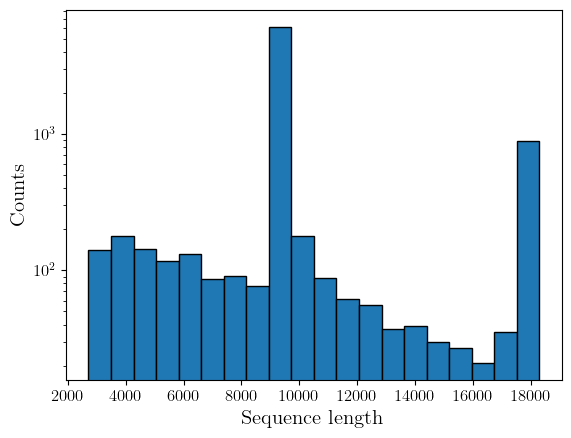

In [192]:
fig, ax = plt.subplots()

ax.hist(label_list['signal length'], bins=20, edgecolor='k')
ax.set_xlabel('Sequence length', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_yscale('log')
plt.show()

Each entry in the dataset contains, apart from the signal array, information such as sample rate (for the signals here is $300\:\rm{Hz}$). The dataset contains four distinct types of ECG recordings (shown below) - (a) normal sinus rhythm (N), (b) afib rhythm (A), (c) other/unclassified rhythm (O) and (d) noise (~). A normal sinus rhythm comprises of distiguishable of P- and T- waves and QRS complexes. Moreover, provided that the recording is being carried out in a steady environment, the time-lapse between successive QRS complexes is constant. The afib rhythm, on the otherhand, apart from unevenly spaced QRS complexes, also display a clear lack of P-waves.

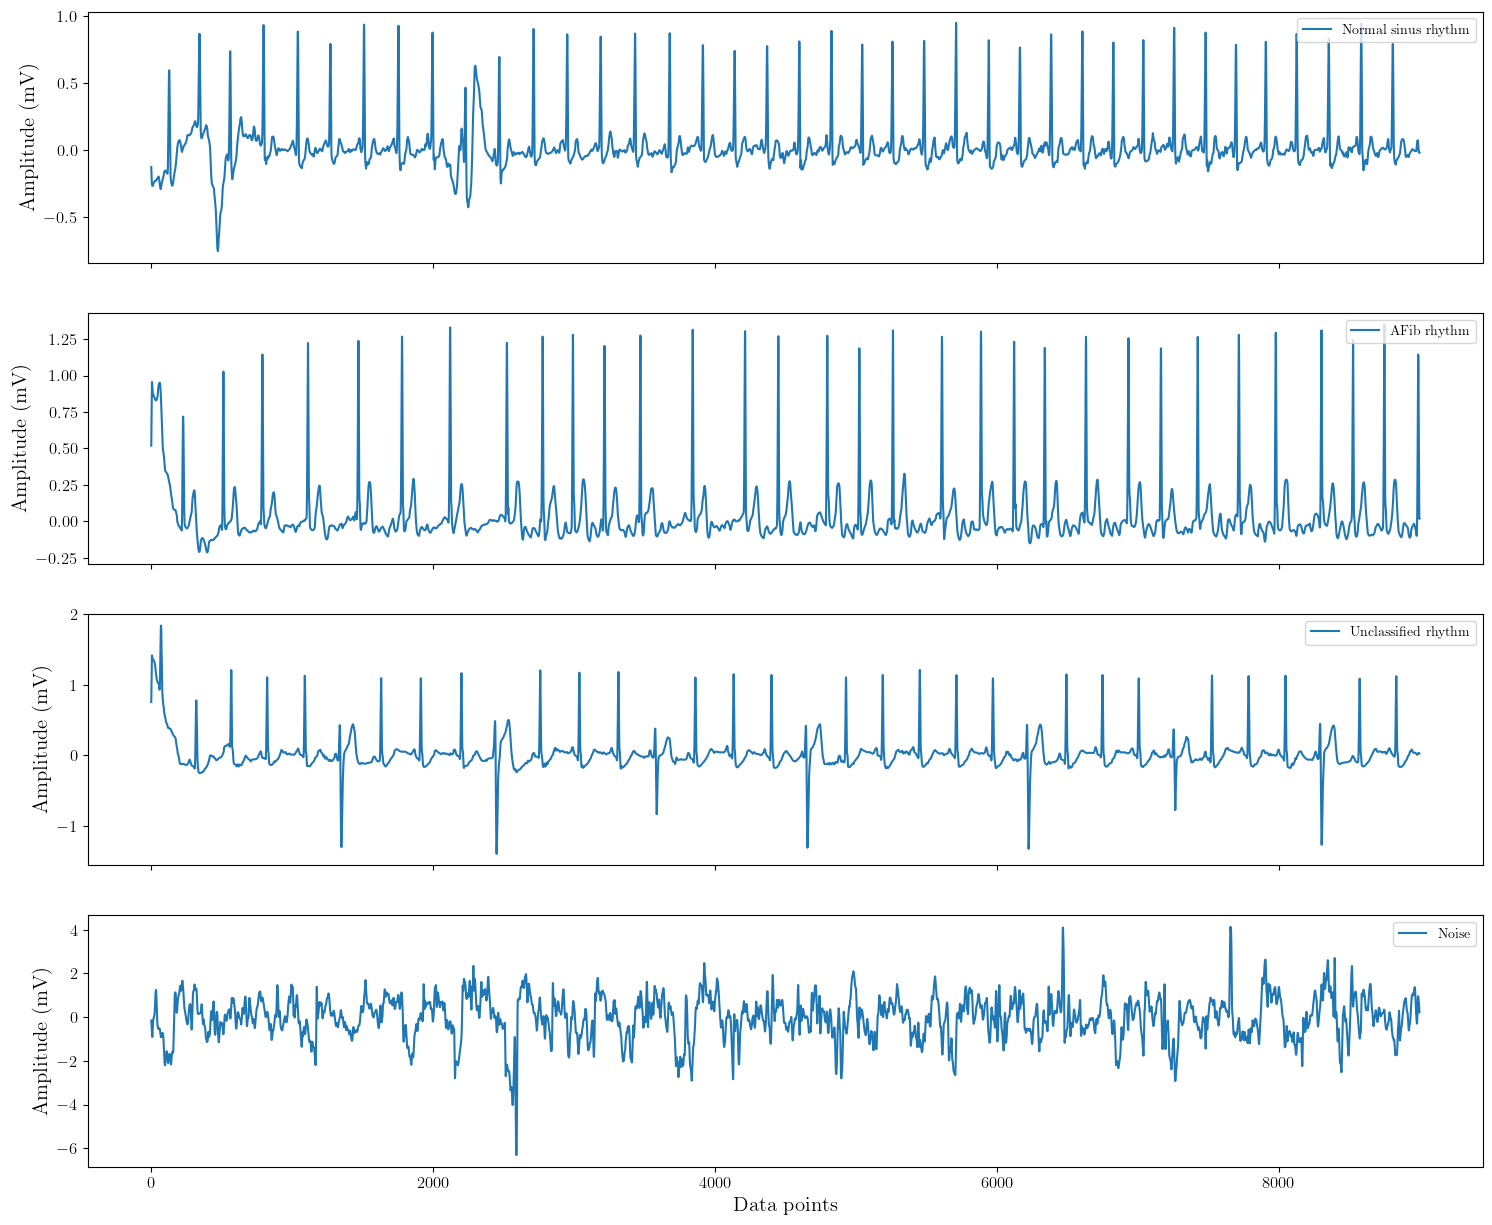

In [135]:
fig, ax = plt.subplots(4, 1, figsize=(18, 15), sharex=True)

ax[0].plot(sample_record(data_list, 0), label='Normal sinus rhythm')
ax[0].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[0].legend(loc='upper right')
ax[1].plot(sample_record(data_list, 3), label='AFib rhythm')
ax[1].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[1].legend(loc='upper right')
ax[2].plot(sample_record(data_list, 76), label='Unclassified rhythm')
ax[2].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[2].legend(loc='upper right')
ax[3].plot(sample_record(data_list, 1245), label='Noise')
ax[3].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[3].set_xlabel(r'Data points', fontsize=15)
ax[3].legend(loc='upper right')

plt.show()

## Identifying features in signals

The features that are present in each cycle of a normal sinus rhythm in ECG signals are 
1. a P-wave representing the electrical depolarization of the atria of the heart, shown as a small positive deflection of the baseline.
2. a QRS complex representing the ventricular contraction (systole), consisting of a Q-wave (the first negative deflection), followed by an R- wave (a strong positive deflection from the baseline) and a subsequent negative dip termed as the S-wave.
3. The QRS complex is followed by a T-wave, which is a small positive deflection similar to the P-wave, indicating ventricular repolarization.

A single ECG cycle is shown below

<img src='./images/ecg.png' class='center' width='600' height='400'>

It can be seen that the time interval between these different P- and T- waves and the QRS complexes also play a big role in determining what an ECG signal looks like. These features can be detected using the Python library *neurokit2*. The signal is first cleaned of noise and passed though nk.ecg_peaks() and nk.ecg_delineate() functions. The nk.ecg_delineate() function can produce a plot of all the ECG cycles stacked with the P- and T- waves and QRS complexes identified. Below, the signal for A00001 is plotted where it can be seen that the different peaks approximately line up when superposed.

In [132]:
def return_peaks(signal):

    signal_trunc = signal[2500:]

    processed_signal = nk.ecg_process(
        signal_trunc,
        sampling_rate=300,
        method='neurokit'
    )

    signal_cleaned = processed_signal[0]['ECG_Clean']
    _, rpeaks = nk.ecg_peaks(signal_cleaned, sampling_rate=300)
    _, wave_peaks = nk.ecg_delineate(
        signal_cleaned,
        rpeaks,
        sampling_rate=300,
        method='dwt',
        show=True,
        show_type='peaks'
    )

    return wave_peaks

P-wave peak locations: [179, 417, 652, 897, 1142, 1376, 1604, 1830, 2064, 2291, 2504, 2725, 2950, 3177, 3405, 3630, 3840, 4073, 4293, 4506, 4725, 4947, 5164, 5374, 5590, 5819, 6054, 6276]


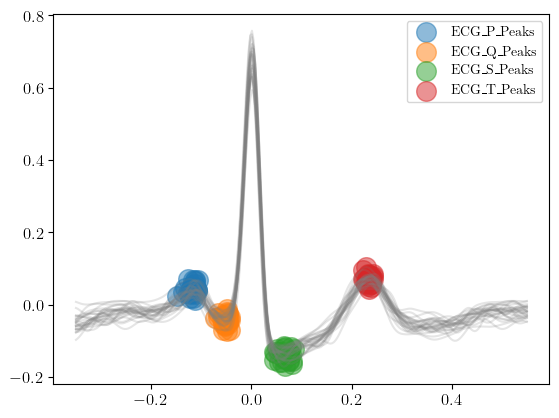

In [133]:
# Record number A00001: normal sinus rhythm

ecg_sig1 = sample_record(data_list,0)

peaks1 = return_peaks(ecg_sig1)

print('P-wave peak locations: ' + str(peaks1['ECG_P_Peaks']))

One the otherhand, when A00004 is plotted using nk.ecg_delineate(), the uneven rhythm means that the ECG cycles cannot be superposed together into a coherent P-QRS-T sequence. Furthermore, a tell-tale sign of atrial fibrillation is the absence of P-waves. In the array wave_peaks2, it can be seen that certain P-waves are shown as NaN.

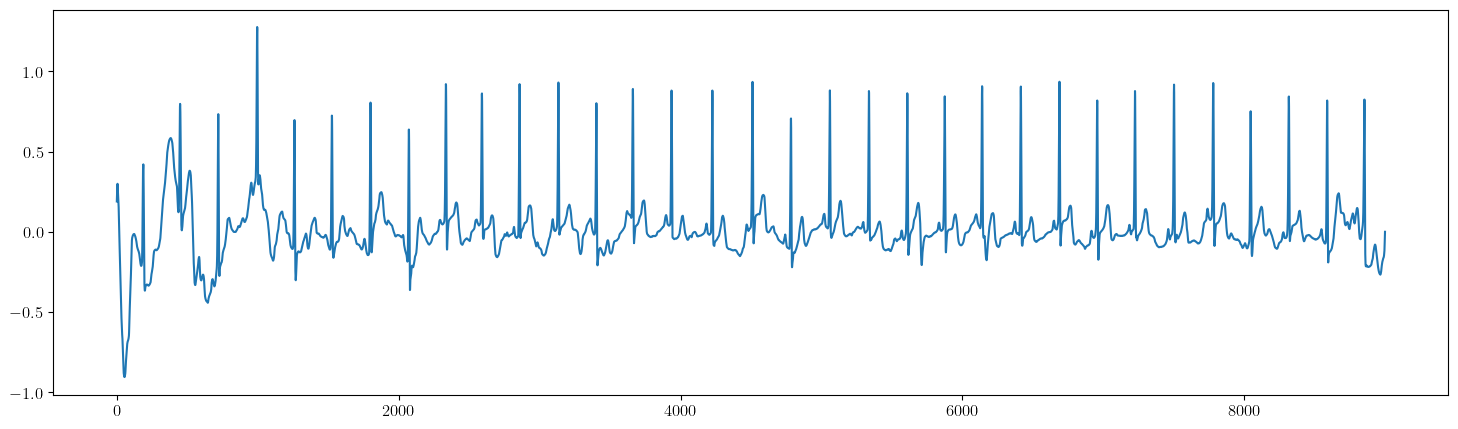

In [166]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(sample_record(data_list,47))
plt.show()

P-wave peak locations: [317, 592, 859, 1121, 1397, 1684, 1970, 2242, 2518, 2795, 3069, 3334, 3598, 3872, 4149, 4417, 4685, 4961, 5240, 5506, 5778, 6047, 6303]


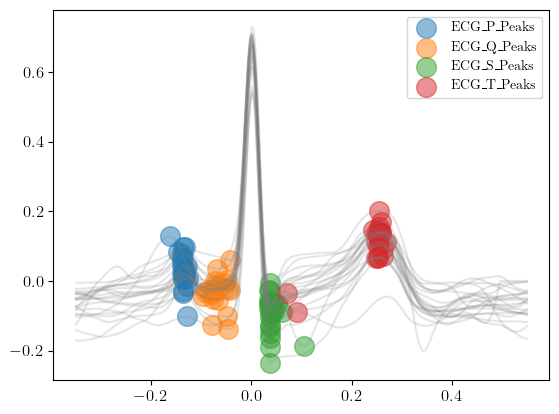

In [167]:
ecg_sig2 = sample_record(data_list,47)

peaks2 = return_peaks(ecg_sig2)

print('P-wave peak locations: ' + str(peaks2['ECG_P_Peaks']))

In [136]:
# missing P-waves in AFib signal

peaks2 

{'ECG_P_Peaks': [240,
  488,
  nan,
  735,
  nan,
  1004,
  nan,
  nan,
  1392,
  1705,
  1906,
  nan,
  2162,
  2283,
  2415,
  2555,
  nan,
  nan,
  2980,
  3134,
  3232,
  3406,
  3558,
  3653,
  3767,
  4052,
  4224,
  4330,
  4441,
  4551,
  4653,
  4802,
  5121,
  5323,
  nan,
  5558,
  5649,
  5761,
  5861,
  5972,
  6080,
  6196,
  6299,
  6414,
  nan,
  6895,
  7152,
  7393,
  nan,
  7653,
  7770,
  7874,
  8132,
  8287,
  nan,
  8479,
  8592,
  nan,
  8988,
  nan,
  nan,
  9332,
  9450,
  9763,
  9945,
  nan,
  10170,
  10281,
  10606,
  10849,
  11007,
  11313,
  11508,
  nan,
  11883,
  nan,
  12148,
  12479,
  12627,
  12737,
  nan,
  13021,
  13326,
  13554,
  13802,
  14042,
  14197,
  14311,
  14411,
  14528,
  14676,
  14814,
  nan,
  15277,
  15429],
 'ECG_P_Onsets': [227,
  nan,
  nan,
  707,
  nan,
  999,
  nan,
  nan,
  1384,
  1692,
  nan,
  nan,
  2143,
  2248,
  2390,
  2548,
  nan,
  nan,
  2974,
  3131,
  3209,
  3385,
  3550,
  3632,
  3751,
  4026,
  4217,
 

In [127]:
#plt.plot(sample_record(data_list, 3)[2300:3100], linewidth=2, color='k')
#plt.scatter(425, -0.075, marker='x', color='r')
#plt.axvline(152, linewidth=1, linestyle='dashed', color='r')
#plt.axvline(631, linewidth=1, linestyle='dashed', color='r')
#plt.annotate('missing P-wave', (350, 0.05), color='r')
#plt.xlabel('Data points', fontsize=15)
#plt.ylabel('Amplitude (mV)', fontsize=15)
#plt.show()

In [168]:
data_list 

['./../data/A00001',
 './../data/A00002',
 './../data/A00003',
 './../data/A00004',
 './../data/A00005',
 './../data/A00006',
 './../data/A00007',
 './../data/A00008',
 './../data/A00009',
 './../data/A00010',
 './../data/A00011',
 './../data/A00012',
 './../data/A00013',
 './../data/A00014',
 './../data/A00015',
 './../data/A00016',
 './../data/A00017',
 './../data/A00018',
 './../data/A00019',
 './../data/A00020',
 './../data/A00021',
 './../data/A00022',
 './../data/A00023',
 './../data/A00024',
 './../data/A00025',
 './../data/A00026',
 './../data/A00027',
 './../data/A00028',
 './../data/A00029',
 './../data/A00030',
 './../data/A00031',
 './../data/A00032',
 './../data/A00033',
 './../data/A00034',
 './../data/A00035',
 './../data/A00036',
 './../data/A00037',
 './../data/A00038',
 './../data/A00039',
 './../data/A00040',
 './../data/A00041',
 './../data/A00042',
 './../data/A00043',
 './../data/A00044',
 './../data/A00045',
 './../data/A00046',
 './../data/A00047',
 './../data/A